# Inertial Forward Backward (Alg. 1B)
initial imports

In [1]:
import numpy as np
import cvxopt
import matplotlib.pyplot as plt
import time
rng = np.random.default_rng()

<IPython.core.display.Javascript object>


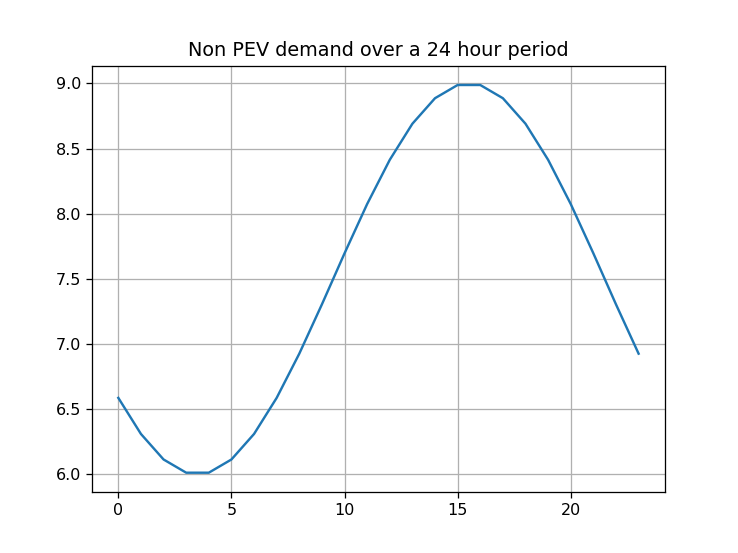

In [2]:
%matplotlib notebook
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

# model the non-PEV demand
def non_pev_demand(t):
    return -1.5*np.sin((1/12)*np.pi*t + 2.5*np.pi*(1/12)) + 7.5
#     return 1.5*np.sin((1/12)*np.pi*t ) + 7.5

def init_xbar(size : int):
    xbar = np.zeros((size,1))
    for i in range(size):
        num = rng.random()
        if (num<=0.8):
            xbar[i] = rng.uniform(low=1, high=5)
    return xbar

### NOTE: agents in here are slightly different from pFB
class Agent:
    def __init__(self, m):
        """constructor, m is the number of rows in vector x, or the time period for this experiment (ie: 24 for 24hrs)"""
        self.Q_i     = np.diag(rng.uniform(low=0.1, high=4, size=m))
        self.p_i     = np.vstack(rng.uniform(low=0.2, high=2, size=m)) # already transposed, ie: p_i is a vertical vect
        self.x_bar_i = init_xbar(m)
        self.l_i     = rng.uniform(low=0.5, high=1.5)

        self.x_k     = rng.random((m,1))  # represents x_k^0, only inits them to be from [0,1)
        self.x_k_tilda = rng.random((m,1)) # x~_k

    def factory_create(n, m):
        """ create and randomly initialise appropriately, 'n' amounts of agents, each agent has "m" time horizons, and delta,
        returns them as an array"""
        return [Agent(m) for i in range(n)]

    def cost_function(self, avg_x, c):
        return 0.5 * (self.x_k.T @ self.Q_i @ self.x_k) + (self.p_i.T @ self.x_k) + ((avg_x + c).T@self.x_k) 

if __name__ == "__main__":
    # plt.figure(figsize=((6.4 * 1.6,4.8 * 1.6)))
    plt.figure()
    plt.plot(np.arange(0,24), non_pev_demand(np.arange(0,24)))
    plt.title("Non PEV demand over a 24 hour period")

    plt.grid()
    plt.savefig("non_pev_demand.png")

In [6]:
m = 24
N = 20
EPSILON = 1e-5

def prox(agent, alpha_i, y):
    """The Proximal operator, needs an Agent object, and the function being acted on, 
    will return the 'x' that achieves the minimum"""
    # Gx <= h
    m = len(agent.x_k)
    G = np.block([[np.identity(m)], 
                [-np.identity(m)], 
                [-np.ones((1,m))]])

    h = np.block([[agent.x_bar_i],
                [np.zeros((m,1))],
                [-agent.l_i]])

    # transform the np.arrays into cvxopt.matrix
    P = cvxopt.matrix(agent.Q_i + np.diag([1/alpha_i]*m))
    q = cvxopt.matrix(agent.p_i - (1/alpha_i) * y)
    h = cvxopt.matrix(h)
    G = cvxopt.matrix(G)

    output = cvxopt.solvers.coneqp(P, q, G, h, options={"show_progress" :False})["x"]

    return output

def plot_agents(list_of_agents, save, legend=False, n=None):
    plt.figure(figsize=((6.4 * 1.4,4.8 * 1.4)))
    ax = plt.subplot(111)
    prev_y = np.zeros(m)
    i=0

    cmap = get_cmap(len(list_of_agents))
    for agent in list_of_agents:
        ax.bar(np.arange(0,m), unraveled_xk := np.ravel(np.array(agent.x_k)), width=1, bottom=prev_y,
                label=f"agent[{i}]",
                color=cmap(i),
                edgecolor="black")
        prev_y += unraveled_xk
        i+=1
        
    if (n==None):
        plt.title(title:=f"Final Plot of all (N={N}) decision variables $x_i$,\n with respect to the time period, using pFB")
    else:
        plt.title(title:=f"Current iteration = {n},\n Plot of all (N={N}) decision variables $x_i$,\n with respect to the time period, using pFB")
    plt.xlabel("time horizon (hour)")
    plt.ylabel("Power (kW)")
    
    # Shrink current axis by 20%
    box = ax.get_position()

    # Put a legend to the right of the current axis
    if legend:
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if save==True:
        plt.savefig(f"./images/{N}_agents_iteration_{n}.png")

plot for initial random agent decisions:


<IPython.core.display.Javascript object>


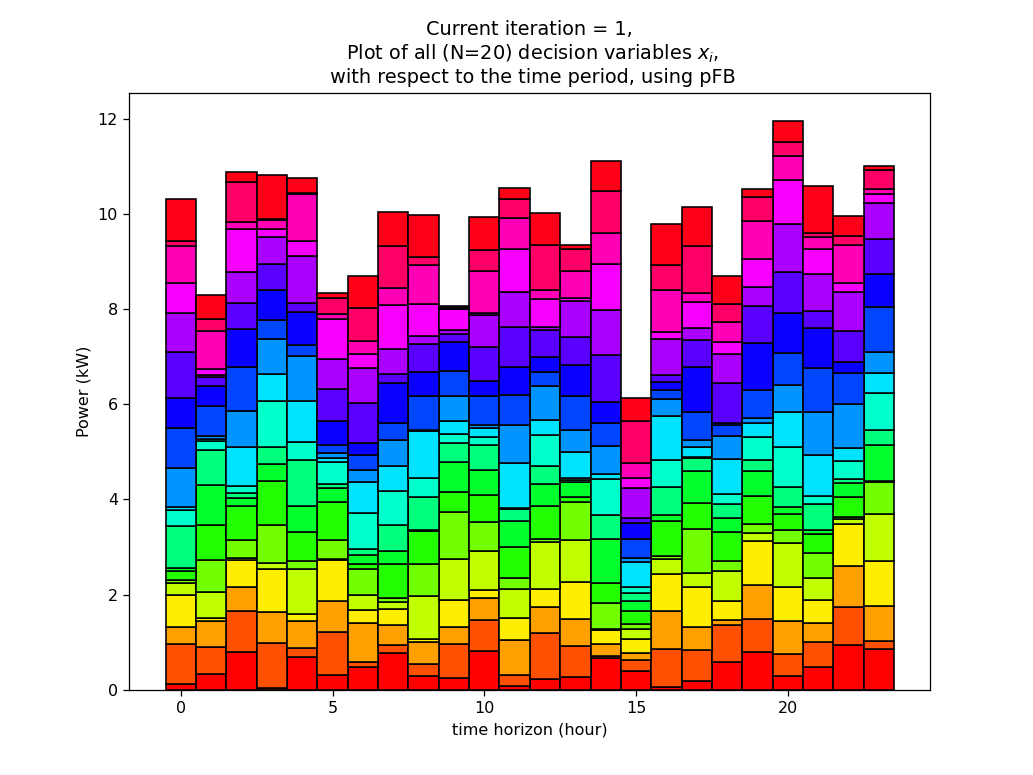

n iterations = 184


<IPython.core.display.Javascript object>


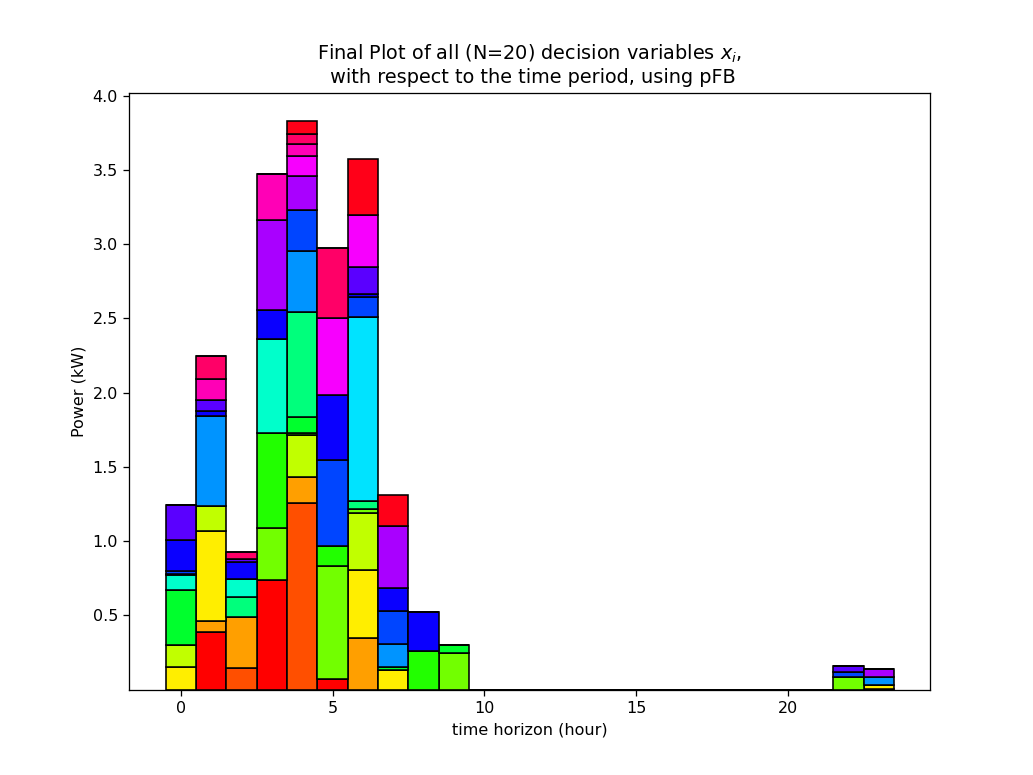

time taken = 57.61944127082825


In [7]:
list_of_agents = Agent.factory_create(N,m)

def perform_inertial(show_progress):
#     theta = 0.33 # must be in [0,1/3)
    theta = 0
    # theoretical Lipschitz and strong monotonicity constant:
    # lip = 1 + (1/N)
    # strong_mono = 1/N, gamma = strong_mono/(lip**2)
    gamma = N/((N**2) + 2*N + 1)

#     delta = (2*lip)/(1-3*theta) * 1.1
    delta =  ((1-theta)**2)/(2*gamma*(1-3*theta))
    ZEROS_VECTOR = np.zeros((m,1))

    alpha_i = (1/(1 + delta)  ) * 0.99
    
    beta = (1/(1 + (delta/N))) * 0.99
    
    b_i = np.full((m,1), fill_value=0.55) # using 0.55kW   (from the function K(t))
    c = np.vstack([non_pev_demand(i) for i in range(m)]) # sampling the non_pev_demand at discrete intervals (per hour)

    A_i = np.eye(m)

    lambd_k      = rng.random((m,1))
    lambd_k_tilda = rng.random((m,1))
 
    
    avg_x_k_tilda = (1/N)*sum([agent.x_k_tilda for agent in list_of_agents])
    
    norm_history = []
    w_k      = np.vstack([agent.x_k for agent in list_of_agents] + [lambd_k])
    w_k_prev = np.zeros((m*N + 1,1))
    norm = 0
    
    while (not norm_history or (norm:=np.linalg.norm(w_k - w_k_prev)) >= EPSILON):   
        norm_history.append(norm)
        
        if show_progress:
            print("norm =", norm)

            # intermediary plotting
            if (len(norm_history) in [2, 10, 50, 100, 150, 200]):
    #             list_of_agents[0].analyse_self()
                plot_agents(list_of_agents, save=True, n=len(norm_history))
        
        if len(norm_history)==1:
            print("plot for initial random agent decisions:")
            plot_agents(list_of_agents, save=False, n=len(norm_history))
        
        # iterate and update agents
        for agent in list_of_agents:
            y_k = agent.x_k_tilda - alpha_i*(avg_x_k_tilda + c + (1/N)*agent.x_k_tilda + lambd_k_tilda)
            
            x_k_next = prox(agent, alpha_i, y_k)
            x_k_tilda_next = x_k_next + theta*(x_k_next - agent.x_k)
            
            agent.d_k_next = 2*x_k_next - agent.x_k_tilda - b_i
            
            agent.x_k = x_k_next
            
            agent.x_k_tilda = x_k_tilda_next

        # central coordinator
        
        # update lambdas
        lambd_k_next = np.maximum(ZEROS_VECTOR, lambd_k_tilda 
                                  + beta*((1/N)*sum([agent.d_k_next for agent in list_of_agents])))
    
        lambd_k_tilda = lambd_k_next + theta*(lambd_k_next - lambd_k)
        lambd_k = lambd_k_next
        
        # update averages for next iteration
        avg_x_k_tilda = (1/N)*sum([agent.x_k_tilda for agent in list_of_agents])
        
        w_k_prev = w_k
        w_k      = np.vstack([agent.x_k for agent in list_of_agents] + [lambd_k])
        
    print("n iterations =", len(norm_history))
    return list_of_agents

if __name__ == "__main__":
    try:
        start = time.time()
        perform_inertial(show_progress=False)
        plot_agents(list_of_agents, save=False)
        print("time taken =", time.time() - start)
        
    except (KeyboardInterrupt):
        plot_agents(list_of_agents, save=False)

In [ ]:
if __name__=="__main__":
#     agents = perform_forb()
    plot_agents(global_agents)